In [58]:
import networkx as nx
import pandas as pd
import json
from typing import DefaultDict
import matplotlib.pyplot as plt
from pyvis.network import Network

In [127]:
path = '../data/gardenplanner.json'

code_dict = {}
relationship_dict = DefaultDict(set)
edibles_dict = DefaultDict(set)

        
def get_plants(path):
    with open(path) as json_file:
        data = json.load(json_file)
        
    edibles = ['fruit', 'herb', 'vegetable']

    for plant in data['plants']:
        if plant['countryCode'] == 'gb':
            code_dict[plant['plantCode']] = plant['plantName']
            relationship_dict[plant['plantCode']] = set(plant['companionPlantCodes'])

            if any(item in plant['tags'] for item in edibles):
                edibles_dict[plant['plantCode']] = set(plant['companionPlantCodes'])
                    
    return code_dict, relationship_dict

code_dict, relationship_dict = get_plants(path)

def print_plant_list(relationship_dict, code_dict):
    for plant in sorted(relationship_dict, key=lambda k: len(relationship_dict[k]), reverse=True):
        print(f'plant: {code_dict[plant]} ({plant}), num_of_companions: {len(relationship_dict[plant])}')

plant: Garlic (GAR), num_of_companions: 24
plant: Nasturtium (NAS), num_of_companions: 23
plant: Carrot (CAR), num_of_companions: 20
plant: Tomato (Cherry) (TOM1), num_of_companions: 19
plant: Lettuce (Loose Leaf) (LET1), num_of_companions: 18
plant: Kale (KAL), num_of_companions: 17
plant: Lettuce (Headed) (LET2), num_of_companions: 17
plant: Tomato (Regular) (TOM2), num_of_companions: 16
plant: Marigold (MAR2), num_of_companions: 16
plant: Brussels Sprouts (BRU), num_of_companions: 15
plant: Thyme (THY), num_of_companions: 15
plant: Lavender (LAV), num_of_companions: 15
plant: Mint (MIN), num_of_companions: 14
plant: Beans (Broad) (BEA1), num_of_companions: 13
plant: Beetroot (BEE), num_of_companions: 13
plant: Onion (ONI), num_of_companions: 13
plant: Swiss Chard (SWI), num_of_companions: 13
plant: Chives (Garlic) (CHI3), num_of_companions: 13
plant: Celery (CEL), num_of_companions: 12
plant: Calabrese (CAL), num_of_companions: 12
plant: Potatoes (Early) (POT1), num_of_companions: 1

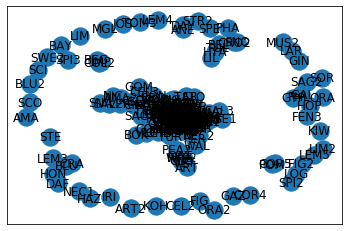

In [120]:
g_all = nx.MultiGraph(relationship_dict)

In [121]:
# show all plant connections
net = Network(notebook = True, width = 1000)
net.from_nx(g_all)
net.show_buttons()
net.show("all_plant_connections.html")

In [128]:
#graph of only veggies, fruits and herbs
g_edible = nx.MultiGraph(edibles_dict)
net = Network(notebook = True, width = 1000)
net.from_nx(g_edible)
net.show_buttons()
net.show("all_plant_connections.html")